# Bayesian MRF for segmentation 
## (Temperature, Temperature Ratio, and 8 neighbors)

In [1]:
import numpy as np
import cv2

Convert XYZ image to L*u*v color space

In [2]:
no_regions = 4
#beta=2.5
#t = 0.05 #threshold
#T0 = 4.00
#c = 0.98

In [3]:
def RGB2Luv(in_data):
    height = in_data.shape[0]
    width = in_data.shape[1]
    xyz_data = np.zeros([height,width,3]).astype("float64")
    luv_data = np.zeros([height,width,3]).astype("float64")
    u0 = 4 * 242.36628 / (242.36628 + 15 * 254.999745 +  3 * 277.63227)
    v0 = 9 * 254.999754 / (242.36628 + 15 * 254.999745 +  3 * 277.63227)
    #Convert into CIE-XYZ color space
    for i in range(height):
        for j in range(width):
            #X component
            xyz_data[i][j][0] = (in_data[i][j][0] * 0.412453 +
                                 in_data[i][j][1] * 0.35758 +
                                 in_data[i][j][2] * 0.180423)
            # Y component
            xyz_data[i][j][1] = (in_data[i][j][0] * 0.212671 +
                                 in_data[i][j][1] * 0.715160 +
                                 in_data[i][j][2] * 0.072169)
            # Z component
            xyz_data[i][j][2] = (in_data[i][j][0] * 0.019334 +
                                 in_data[i][j][1] * 0.119193 +
                                 in_data[i][j][2] * 0.950227)
    #Convert into CIE-L*u*v color space
    for i in range(height):
        for j in range(width):
            if ((xyz_data[i][j][1]/254.999745) > 0.008856):
                luv_data[i][j][0] = 116*np.power(xyz_data[i][j][1]/264.999745, 1/3)-16
            else:
                luv_data[i][j][0] = 903.3*(xyz_data[i][j][1]/254.999745)
            #u component
            if ((xyz_data[i][j][0] + 15 * xyz_data[i][j][1] + 3 * xyz_data[i][j][2])==0):
                luv_data[i][j][1] = 13 * luv_data[i][j][0] * (-u0)
            else:
                luv_data[i][j][1] = 13 * luv_data[i][j][0] * ((4 * xyz_data[i][j][0]/
                                                               (xyz_data[i][j][0] + 15 * xyz_data[i][j][1] + 3 * xyz_data[i][j][2])) - u0)
    
            #v component
            if ((xyz_data[i][j][0] + 15 * xyz_data[i][j][1] + 3 * xyz_data[i][j][2])==0):
                luv_data[i][j][2] = 13 * luv_data[i][j][0] * (-v0)
            else:
                luv_data[i][j][2] = 13 * luv_data[i][j][0] * ((9 * xyz_data[i][j][1] /
                                                               (xyz_data[i][j][0] + 15 * xyz_data[i][j][1] + 3 * xyz_data[i][j][2])) - v0)
    
    return luv_data

Prior Guanssian distribution parameters

In [4]:
def CalculateMeanAndCovariance(frame):
    h=frame.shape[0]
    w=frame.shape[1]
    variance = np.zeros(3).astype("float64")
    mean = np.zeros(3).astype("float64")
    covariance = np.zeros(3).astype("float64")
    invcov = np.zeros(6).astype("float64")
    for k in range(3):
        frame_LUV = np.reshape(frame[:,:,k], -1)
        mean[k] = np.mean(frame_LUV)
        variance[k] = np.var(frame_LUV,ddof=1)
    #compute covariances
    frame_L = np.reshape(frame[:,:,0], -1)
    frame_u = np.reshape(frame[:,:,1], -1)
    frame_v = np.reshape(frame[:,:,2], -1)
    mean_L = mean[0]
    mean_u = mean[1]
    mean_v = mean[2]
    covariance[0] = np.sum((frame_L - mean_L)*(frame_u - mean_u))/(w*h)
    covariance[1] = np.sum((frame_L - mean_L)*(frame_v - mean_v))/(w*h)
    covariance[2] = np.sum((frame_u - mean_u)*(frame_v - mean_v))/(w*h)

    #compute elements of inverse covariance matrix
    invcov[0] = variance[2]*variance[1]-covariance[2]*covariance[2]
    invcov[1] = covariance[1]*covariance[2]-variance[2]*covariance[0]
    invcov[2] = covariance[0]*covariance[2]-variance[1]*covariance[1]
    invcov[3] = variance[2]*variance[0]-covariance[1]*covariance[1]
    invcov[4] = covariance[0]*covariance[1]-variance[0]*covariance[2]
    invcov[5] = variance[1]*variance[0]-covariance[0]*covariance[0]

    #compute denominator
    denom =  variance[0] * variance[1] * variance[2] - \
                          variance[2] * covariance[0] * covariance[0] - \
                          variance[1] * covariance[1] * covariance[1] - \
                          variance[0] * covariance[2] * covariance[2] + \
                          covariance[0] * covariance[1] * covariance[2] * 2
    return mean, variance, covariance, invcov, denom


Get mean etc.

In [5]:
mean = np.zeros([no_regions,3]).astype("float64")
variance = np.zeros([no_regions, 3]).astype("float64")
covariance = np.zeros([no_regions, 3]).astype("float64")
invcov = np.zeros([no_regions, 6]).astype("float64")
denom = np.zeros([no_regions]).astype("float64")
img = '../input/color_18.bmp'
img = cv2.imread(img, cv2.COLOR_RGB2BGR)
img1 = img.astype('float64')
img3 = RGB2Luv(img1)
image_height, image_width = img3.shape[0], img3.shape[1]
points = np.array([[(0,0),(4,4)],[(32,0),(36,4)],[(64,64),(68,68)],[(96,96),(100,100)]])
i=0
for refPoint in points:
    frame_i = img3[refPoint[0][1]:refPoint[1][1], refPoint[0][0]:refPoint[1][0]]
    print(frame_i)
    mean[i], variance[i], covariance[i], invcov[i], denom[i] = CalculateMeanAndCovariance(frame_i)
    i+=1
mean=(mean.T)
variance=(variance.T)
covariance=(covariance.T)
invcov=(invcov.T)
denom=(denom.T)
print(mean)
print(variance)
print(covariance)
print(invcov)
print(denom)

[[[ 80.88182264 -13.37101162 -23.26132423]
  [ 75.54926929  -6.85337765 -18.9753057 ]
  [ 78.92309235  -7.63346399 -21.51656624]
  [ 78.60602432  -2.10281156 -24.71027945]]

 [[ 74.33876368   1.54983373 -26.3076912 ]
  [ 80.67709097 -20.89273836 -15.33927315]
  [ 77.88270032  -4.51172519 -26.77571749]
  [ 79.9374046   -7.4419278  -14.79663566]]

 [[ 77.98560748 -14.44588336 -18.49225225]
  [ 77.88226326  -7.97925473 -14.07374455]
  [ 75.96385184  -2.32823942 -27.64373988]
  [ 75.36806594  -8.23345706 -24.72371546]]

 [[ 77.75810562  -8.50217073 -22.96935825]
  [ 78.14099101 -10.88428665 -19.88098832]
  [ 81.46839312  -9.81610306 -10.31734453]
  [ 77.25106611   0.44297309 -21.3179925 ]]]
[[[ 60.03398449  38.02948044 -45.16434917]
  [ 62.20542173  33.22464575 -36.40914274]
  [ 66.39908602  29.65885387 -17.49288215]
  [ 62.93562704  29.12926166 -32.4418841 ]]

 [[ 61.14673843  24.9148304  -38.84286997]
  [ 66.03749812  24.08075119 -40.11408214]
  [ 62.07161027  31.96422075 -46.41205609]
 

In [6]:
def Singleton( i, j, label, image, mean, variance, covariance, invcov, denom):
    #determinate of covariance matrix
    in_image_data = image
    #print("Singleletion:", label)

    det = variance[0][label]*variance[1][label]*variance[2][label] + \
          2 * covariance[0][label]*covariance[1][label]*covariance[0][label] -\
          covariance[0][label]*covariance[0][label]*variance[2][label] - \
          covariance[1][label]*covariance[1][label]*variance[1][label] - \
          covariance[2][label]*covariance[2][label]*variance[0][label]

    gauss = ((in_image_data[i][j][0]-mean[0][label]) * invcov[0][label] + \
             (in_image_data[i][j][1]-mean[1][label]) * invcov[1][label] +\
             (in_image_data[i][j][2]-mean[2][label]) * invcov[2][label]) * (in_image_data[i][j][0]-mean[0][label]) + \
            ((in_image_data[i][j][0]-mean[0][label]) * invcov[1][label] + \
             (in_image_data[i][j][1]-mean[1][label]) * invcov[3][label] + \
             (in_image_data[i][j][2]-mean[2][label]) * invcov[4][label]) * (in_image_data[i][j][1]-mean[1][label]) +\
            ((in_image_data[i][j][0]-mean[0][label]) * invcov[2][label] + \
             (in_image_data[i][j][1]-mean[1][label]) * invcov[4][label] + \
             (in_image_data[i][j][2]-mean[2][label]) * invcov[5][label]) * (in_image_data[i][j][2]-mean[2][label])
    #print("in_image:",in_image_data[i][j], "-", mean[:,label])
    #print("gauss:",gauss)
    if(det==0):
        det = 1e-10
    elif(det < 0):
        det = -det
    if(denom[label]==0):
        denom[label]=1e-10
    return np.log(np.sqrt(2.0*np.pi*det)) + 0.5 * gauss / denom[label]

Analysis the data distrubution
The Singleletion vary with mean and variance

In [7]:
'''
singleenergy = []
for i in range(1000):
    mean = np.zeros([1,3])
    variance = np.zeros([1,3])
    covariance = np.zeros([1,3])
    invcov = np.zeros([1,6])
    denom = np.zeros([1])
    rgb_array = np.random.rand(3,3,3) * 255
    rgb_array = rgb_array.astype('uint8')
    img1 = img.astype('float32')
    img2 = cv2.cvtColor(img1, cv2.COLOR_RGB2XYZ)
    img3 = RGB2Luv(img2)
    height, width = img3.shape[0], img3.shape[1]
    mean[0], variance[0], covariance[0], invcov[0], denom[0] = CalculateMeanAndCovariance(rgb_array)
    mean=(mean.T)
    variance=(variance.T)
    covariance=(covariance.T)
    invcov=(invcov.T)
    denom=(denom.T)
    denom[denom==0]=1e-10
    singleenergy.append(Singleletion(0, 0, 0, img3, mean, variance, covariance, invcov, denom))

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.plot(singleenergy)
plt.xlabel('Data', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.grid(b=True, which='major', color='DarkTurquoise', alpha=0.4, linestyle=':', linewidth=2)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='beige', alpha=0.2, linestyle='-', linewidth=2)
plt.show()
'''

"\nsingleenergy = []\nfor i in range(1000):\n    mean = np.zeros([1,3])\n    variance = np.zeros([1,3])\n    covariance = np.zeros([1,3])\n    invcov = np.zeros([1,6])\n    denom = np.zeros([1])\n    rgb_array = np.random.rand(3,3,3) * 255\n    rgb_array = rgb_array.astype('uint8')\n    img1 = img.astype('float32')\n    img2 = cv2.cvtColor(img1, cv2.COLOR_RGB2XYZ)\n    img3 = RGB2Luv(img2)\n    height, width = img3.shape[0], img3.shape[1]\n    mean[0], variance[0], covariance[0], invcov[0], denom[0] = CalculateMeanAndCovariance(rgb_array)\n    mean=(mean.T)\n    variance=(variance.T)\n    covariance=(covariance.T)\n    invcov=(invcov.T)\n    denom=(denom.T)\n    denom[denom==0]=1e-10\n    singleenergy.append(Singleletion(0, 0, 0, img3, mean, variance, covariance, invcov, denom))\n\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport scipy.stats as stats\nplt.plot(singleenergy)\nplt.xlabel('Data', fontsize=15)\nplt.ylabel('Value', fontsize=15)\nplt.grid(b=True, which='major', co

In [8]:
"""
Get the energy of the neighbors for each pixel and 
return the sum of their energies multiplied by beta 
in oder to calculate the doubletons 
(Doubleton: favours similar labels at neighbouring pixels – smoothness prior)
"""
def Doubleton(i, j, label, classes, beta, neighbors=4):
    energy = 0
    image_height, image_width = classes.shape[0], classes.shape[1]
    #print("Doubleton:", image_height, "x", image_width)
    #print("Doubleton: beta:", beta)
    #south
    if(i != image_height-1):
        if(label == classes[i+1][j]):
            energy -= 1
        else:
            energy += 1
    #east
    if(j != image_width-1):
        if(label == classes[i][j+1]):
            energy -= 1
        else:
            energy += 1
    #north
    if(i != 0):
        if(label == classes[i-1][j]):
            energy -= 1
        else:
            energy += 1
    #west
    if(i != image_height-1):
        if(label == classes[i][j-1]):
            energy -= 1
        else:
            energy += 1
    if(neighbors == 8):
            #southeast
            if(i != image_height-1) and (j != image_width-1):
                if(label == classes[i+1][j+1]):
                    energy -= 1
                else:
                    energy += 1
            #northeast
            if(i != 0) and (j != image_width-1):
                if(label == classes[i-1][j+1]):
                    energy -= 1
                else:
                    energy += 1
            #northwest
            if(i != 0) and (j != 0):
                if(label == classes[i-1][j-1]):
                    energy -= 1
                else:
                    energy += 1
            #southwest
            if(i != image_height-1) and (j != 0):
                if(label == classes[i][j-1]):
                    energy -= 1
                else:
                    energy += 1

    return energy*beta

In [9]:
def LocalEnergy(i, j, label, image, classes, mean, variance, covariance, invcov, denom, beta, neighbors):
    return Singleton(i,j,label,image,mean,variance,covariance,invcov,denom)+Doubleton(i,j,label,classes,beta,neighbors)

In [10]:
def CalculateEnergy(image, classes, mean, variance, covariance, invcov, denom, beta, neighbors):
    singletons = 0
    doubletons = 0
    global image_height, image_width
    for i in range(image_height):
        for j in range(image_width):
            k = classes[i,j]
            singletons += Singleton(i,j,k,image,mean, variance, covariance, invcov, denom)
            doubletons += Doubleton(i,j,k,classes,beta, neighbors) #each doubleton is counted twice
    #print("singletons:",singletons)
    #print("doubletons:",doubletons/2)
    return singletons+(doubletons/2)

In [11]:
# initialize using Maximum Likelihood
def SetInitClasses(image, mean, variance, covariance, invcov, denom):
    singletons = 0
    global image_height, image_width, no_regions
    classes = np.zeros([image_height, image_width]).astype("uint8")
    for i in range(image_height):
        for j in range(image_width):
            classes[i][j]=0
            e=Singleton(i,j,0,image, mean, variance, covariance, invcov, denom)
            for k in range(no_regions):
                e2 = Singleton(i,j,k,image, mean, variance, covariance, invcov, denom)
                if(e2 < e):
                    e = e2
                    classes[i,j] = k
    return classes

In [12]:
InitClasses = SetInitClasses(img3, mean, variance, covariance, invcov, denom)
print(InitClasses)

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [13]:
#gibbs sample
def gibbs(image, mean, variance, covariance, invcov, denom,beta, T0, c, t, neighbors=4):
    image_height, image_width = image.shape[0], image.shape[1]
    wholeEnergy = []
    wholeT = []
    Ek = np.zeros(no_regions) #local enegies
    classes = np.zeros([image_height, image_width]).astype('uint8')
    T = T0
    InitClasses = SetInitClasses(img3, mean, variance, covariance, invcov, denom)
    E_old = CalculateEnergy(image, InitClasses, mean, variance, covariance, invcov, denom,beta,neighbors)
    iterNo = 0
    while True:
        summa_deltaE = 0
        for i in range(image_height):
            for j in range(image_width):
                sumE = 0
                for s in range(no_regions):
                    Ek[s] = np.exp(-LocalEnergy(i,j,s,image,classes, mean, variance, covariance, invcov, denom,beta,neighbors)/T)
                    sumE +=Ek[s]
                #CDF
                z = 0
                r=np.random.uniform(size=1)
                for s in range(no_regions):
                    z +=Ek[s]/sumE
                    if(z>r):
                        classes[i][j]=s
                        break

        E = CalculateEnergy(image, classes, mean, variance, covariance, invcov, denom, beta,neighbors)
        summa_deltaE += np.abs(E_old-E)
        E_old = E
        T *= c
        iterNo += 1
        wholeT.append(T)
        wholeEnergy.append(E_old)
        #print("summa_deltaE:", summa_deltaE)
        print("T:", T)
        #print("Energy:", E)
        print('iterNo:', iterNo)

        if (summa_deltaE < t): # stop when energy change is small
            return classes, wholeEnergy, wholeT
            break

In [14]:
def outConvert(classes):
    classes = np.reshape(classes,(128,128))
    out_image = np.zeros([128,128,3]).astype("uint8")
    for i in range(128):
        for j in range(128):
            if(classes[i][j]==0):
                out_image[i][j] = [219,182,125]#[125,182,219]
            elif(classes[i][j]==1):
                out_image[i][j] = [112,42,156]#[156, 42,112]
            elif(classes[i][j]==2):
                out_image[i][j] = [208,6,204]#[204,  6,208]
            elif(classes[i][j]==3):
                out_image[i][j] = [81,145,30]#[ 30,145, 81]
            else:
                out_image[i][j] = [ 0,0,255]
                
    return out_image

## 4 neighbors

In [15]:
import time
N4Noises = [18, 26, 33, 59, 105]
N4OutImageList = []
N4WholeEnergyList = []
N4WholeTList = []
N4PSNRList = []
beta = 2.5
T0 = 4
c=0.98
threshold=0.05
for k in range(len(N4Noises)):
    start_time = time.time()
    
    mean = np.zeros([no_regions,3]).astype("float64")
    variance = np.zeros([no_regions, 3]).astype("float64")
    covariance = np.zeros([no_regions, 3]).astype("float64")
    invcov = np.zeros([no_regions, 6]).astype("float64")
    denom = np.zeros([no_regions]).astype("float64")
    
    img = '../input/color_'+str(N4Noises[k])+'.bmp'
    print(img)
    OriImg = cv2.imread(img)
    img = cv2.cvtColor(OriImg, cv2.COLOR_RGB2BGR)
    img1 = img.astype('float64')
    img3 = RGB2Luv(img1)
    points = np.array([[(0,0),(4,4)],[(32,0),(36,4)],[(64,64),(68,68)],[(96,96),(100,100)]])
    i=0
    for refPoint in points:
        frame_i = img3[refPoint[0][1]:refPoint[1][1], refPoint[0][0]:refPoint[1][0]]
        mean[i], variance[i], covariance[i], invcov[i], denom[i] = CalculateMeanAndCovariance(frame_i)
        i+=1
    mean=(mean.T)
    variance=(variance.T)
    covariance=(covariance.T)
    invcov=(invcov.T)
    denom=(denom.T)
    #4 neighbors
    classes, wholeEnergy, wholeT=gibbs(img3, mean, variance, covariance, invcov, denom, beta, T0, c, threshold)
    timespent=(time.time()-start_time)/len(wholeEnergy)
    print(["Average time:"+str(timespent)])
    OutImage=outConvert(classes)
    psnr = cv2.PSNR(OriImg, OutImage.astype('uint8'))
    print(["4 neighbors PSNR:"+str(psnr)])
    N4PSNRList.append(psnr)
    N4OutImageList.append(OutImage)
    N4WholeEnergyList.append(wholeEnergy)
    N4WholeTList.append(wholeT)
    

../input/color_18.bmp
T: 3.92
iterNo: 1
T: 3.8415999999999997
iterNo: 2
T: 3.7647679999999997
iterNo: 3
T: 3.6894726399999995
iterNo: 4
T: 3.6156831871999993
iterNo: 5
T: 3.543369523455999
iterNo: 6
T: 3.4725021329868793
iterNo: 7
T: 3.4030520903271415
iterNo: 8
T: 3.3349910485205987
iterNo: 9
T: 3.2682912275501868
iterNo: 10
T: 3.202925402999183
iterNo: 11
T: 3.1388668949391993
iterNo: 12
T: 3.076089557040415
iterNo: 13
T: 3.014567765899607
iterNo: 14
T: 2.9542764105816146
iterNo: 15
T: 2.8951908823699823
iterNo: 16
T: 2.8372870647225827
iterNo: 17
T: 2.780541323428131
iterNo: 18
T: 2.7249304969595682
iterNo: 19
T: 2.670431887020377
iterNo: 20
T: 2.617023249279969
iterNo: 21
['Average time:2.7228995164235434']
['4 neighbors PSNR:13.772435189343387']
../input/color_26.bmp
T: 3.92
iterNo: 1
T: 3.8415999999999997
iterNo: 2
T: 3.7647679999999997
iterNo: 3
T: 3.6894726399999995
iterNo: 4
T: 3.6156831871999993
iterNo: 5
T: 3.543369523455999
iterNo: 6
T: 3.4725021329868793
iterNo: 7
T: 3.403

T: 0.9724903259906462
iterNo: 70
T: 0.9530405194708332
iterNo: 71
T: 0.9339797090814166
iterNo: 72
T: 0.9153001148997882
iterNo: 73
T: 0.8969941126017925
iterNo: 74
T: 0.8790542303497566
iterNo: 75
T: 0.8614731457427615
iterNo: 76
T: 0.8442436828279062
iterNo: 77
T: 0.8273588091713481
iterNo: 78
T: 0.8108116329879211
iterNo: 79
T: 0.7945954003281627
iterNo: 80
T: 0.7787034923215994
iterNo: 81
T: 0.7631294224751675
iterNo: 82
T: 0.7478668340256641
iterNo: 83
T: 0.7329094973451509
iterNo: 84
T: 0.7182513073982478
iterNo: 85
T: 0.7038862812502829
iterNo: 86
T: 0.6898085556252772
iterNo: 87
T: 0.6760123845127717
iterNo: 88
T: 0.6624921368225163
iterNo: 89
T: 0.6492422940860659
iterNo: 90
T: 0.6362574482043446
iterNo: 91
T: 0.6235322992402577
iterNo: 92
T: 0.6110616532554525
iterNo: 93
T: 0.5988404201903434
iterNo: 94
T: 0.5868636117865366
iterNo: 95
T: 0.5751263395508058
iterNo: 96
T: 0.5636238127597897
iterNo: 97
T: 0.5523513365045939
iterNo: 98
T: 0.5413043097745021
iterNo: 99
T: 0.53047

T: 0.2317056713656215
iterNo: 141
T: 0.22707155793830908
iterNo: 142
T: 0.2225301267795429
iterNo: 143
T: 0.21807952424395202
iterNo: 144
T: 0.21371793375907297
iterNo: 145
T: 0.2094435750838915
iterNo: 146
T: 0.20525470358221368
iterNo: 147
T: 0.2011496095105694
iterNo: 148
T: 0.197126617320358
iterNo: 149
T: 0.19318408497395084
iterNo: 150
T: 0.18932040327447183
iterNo: 151
T: 0.1855339952089824
iterNo: 152
T: 0.18182331530480275
iterNo: 153
T: 0.17818684899870668
iterNo: 154
T: 0.17462311201873254
iterNo: 155
T: 0.17113064977835787
iterNo: 156
T: 0.16770803678279073
iterNo: 157
T: 0.16435387604713492
iterNo: 158
T: 0.1610667985261922
iterNo: 159
T: 0.15784546255566836
iterNo: 160
T: 0.154688553304555
iterNo: 161
T: 0.1515947822384639
iterNo: 162
T: 0.14856288659369463
iterNo: 163
T: 0.14559162886182073
iterNo: 164
T: 0.1426797962845843
iterNo: 165
T: 0.13982620035889262
iterNo: 166
T: 0.13702967635171476
iterNo: 167
T: 0.13428908282468047
iterNo: 168
['Average time:2.35386223310516'

# 8 neighbors

In [16]:
N8OutImageList = []
N8WholeEnergyList = []
N8WholeTList = []
N8PSNRList = []
for k in range(len(N4Noises)):
    start_time = time.time()
    
    mean = np.zeros([no_regions,3]).astype("float64")
    variance = np.zeros([no_regions, 3]).astype("float64")
    covariance = np.zeros([no_regions, 3]).astype("float64")
    invcov = np.zeros([no_regions, 6]).astype("float64")
    denom = np.zeros([no_regions]).astype("float64")
    
    img = '../input/color_'+str(N4Noises[k])+'.bmp'
    print(img)
    OriImg = cv2.imread(img)
    img = cv2.cvtColor(OriImg, cv2.COLOR_RGB2BGR)
    img1 = img.astype('float64')
    img3 = RGB2Luv(img1)
    points = np.array([[(0,0),(4,4)],[(32,0),(36,4)],[(64,64),(68,68)],[(96,96),(100,100)]])
    i=0
    for refPoint in points:
        frame_i = img3[refPoint[0][1]:refPoint[1][1], refPoint[0][0]:refPoint[1][0]]
        mean[i], variance[i], covariance[i], invcov[i], denom[i] = CalculateMeanAndCovariance(frame_i)
        i+=1
    mean=(mean.T)
    variance=(variance.T)
    covariance=(covariance.T)
    invcov=(invcov.T)
    denom=(denom.T)
    #4 neighbors
    classes, wholeEnergy, wholeT=gibbs(img3, mean, variance, covariance, invcov, denom, beta, T0, c, threshold)
    timespent=(time.time()-start_time)/len(wholeEnergy)
    print(["Average time:"+str(timespent)])
    OutImage=outConvert(classes)
    psnr = cv2.PSNR(OriImg, OutImage.astype('uint8'))
    print(["8 neighbors PSNR:"+str(psnr)])
    N8PSNRList.append(psnr)
    N8OutImageList.append(OutImage)
    N8WholeEnergyList.append(wholeEnergy)
    N8WholeTList.append(wholeT)

../input/color_18.bmp
T: 3.92
iterNo: 1
T: 3.8415999999999997
iterNo: 2
T: 3.7647679999999997
iterNo: 3
T: 3.6894726399999995
iterNo: 4
T: 3.6156831871999993
iterNo: 5
T: 3.543369523455999
iterNo: 6
T: 3.4725021329868793
iterNo: 7
T: 3.4030520903271415
iterNo: 8
T: 3.3349910485205987
iterNo: 9
T: 3.2682912275501868
iterNo: 10
T: 3.202925402999183
iterNo: 11
T: 3.1388668949391993
iterNo: 12
T: 3.076089557040415
iterNo: 13
T: 3.014567765899607
iterNo: 14
T: 2.9542764105816146
iterNo: 15
T: 2.8951908823699823
iterNo: 16
T: 2.8372870647225827
iterNo: 17
T: 2.780541323428131
iterNo: 18
T: 2.7249304969595682
iterNo: 19
T: 2.670431887020377
iterNo: 20
T: 2.617023249279969
iterNo: 21
['Average time:2.4654404549371627']
['8 neighbors PSNR:13.772435189343387']
../input/color_26.bmp
T: 3.92
iterNo: 1
T: 3.8415999999999997
iterNo: 2
T: 3.7647679999999997
iterNo: 3
T: 3.6894726399999995
iterNo: 4
T: 3.6156831871999993
iterNo: 5
T: 3.543369523455999
iterNo: 6
T: 3.4725021329868793
iterNo: 7
T: 3.403

T: 2.617023249279969
iterNo: 21
T: 2.56468278429437
iterNo: 22
T: 2.513389128608482
iterNo: 23
T: 2.4631213460363126
iterNo: 24
T: 2.413858919115586
iterNo: 25
T: 2.3655817407332744
iterNo: 26
T: 2.318270105918609
iterNo: 27
T: 2.271904703800237
iterNo: 28
T: 2.2264666097242323
iterNo: 29
T: 2.1819372775297476
iterNo: 30
T: 2.1382985319791525
iterNo: 31
T: 2.0955325613395694
iterNo: 32
T: 2.053621910112778
iterNo: 33
T: 2.0125494719105226
iterNo: 34
T: 1.972298482472312
iterNo: 35
T: 1.9328525128228657
iterNo: 36
T: 1.8941954625664084
iterNo: 37
T: 1.8563115533150802
iterNo: 38
T: 1.8191853222487786
iterNo: 39
T: 1.782801615803803
iterNo: 40
T: 1.7471455834877267
iterNo: 41
T: 1.7122026718179721
iterNo: 42
T: 1.6779586183816126
iterNo: 43
T: 1.6443994460139804
iterNo: 44
T: 1.6115114570937008
iterNo: 45
T: 1.5792812279518267
iterNo: 46
T: 1.5476956033927902
iterNo: 47
T: 1.5167416913249343
iterNo: 48
T: 1.4864068574984355
iterNo: 49
T: 1.4566787203484668
iterNo: 50
T: 1.427545145941497

T: 0.2563340418606259
iterNo: 136
T: 0.2512073610234134
iterNo: 137
T: 0.24618321380294514
iterNo: 138
T: 0.24125954952688622
iterNo: 139
T: 0.23643435853634848
iterNo: 140
T: 0.2317056713656215
iterNo: 141
T: 0.22707155793830908
iterNo: 142
T: 0.2225301267795429
iterNo: 143
['Average time:2.3709182705912557']
['8 neighbors PSNR:10.555434062911235']


In [17]:
print(len(N4Noises))
print(len(N4OutImageList))

5
5


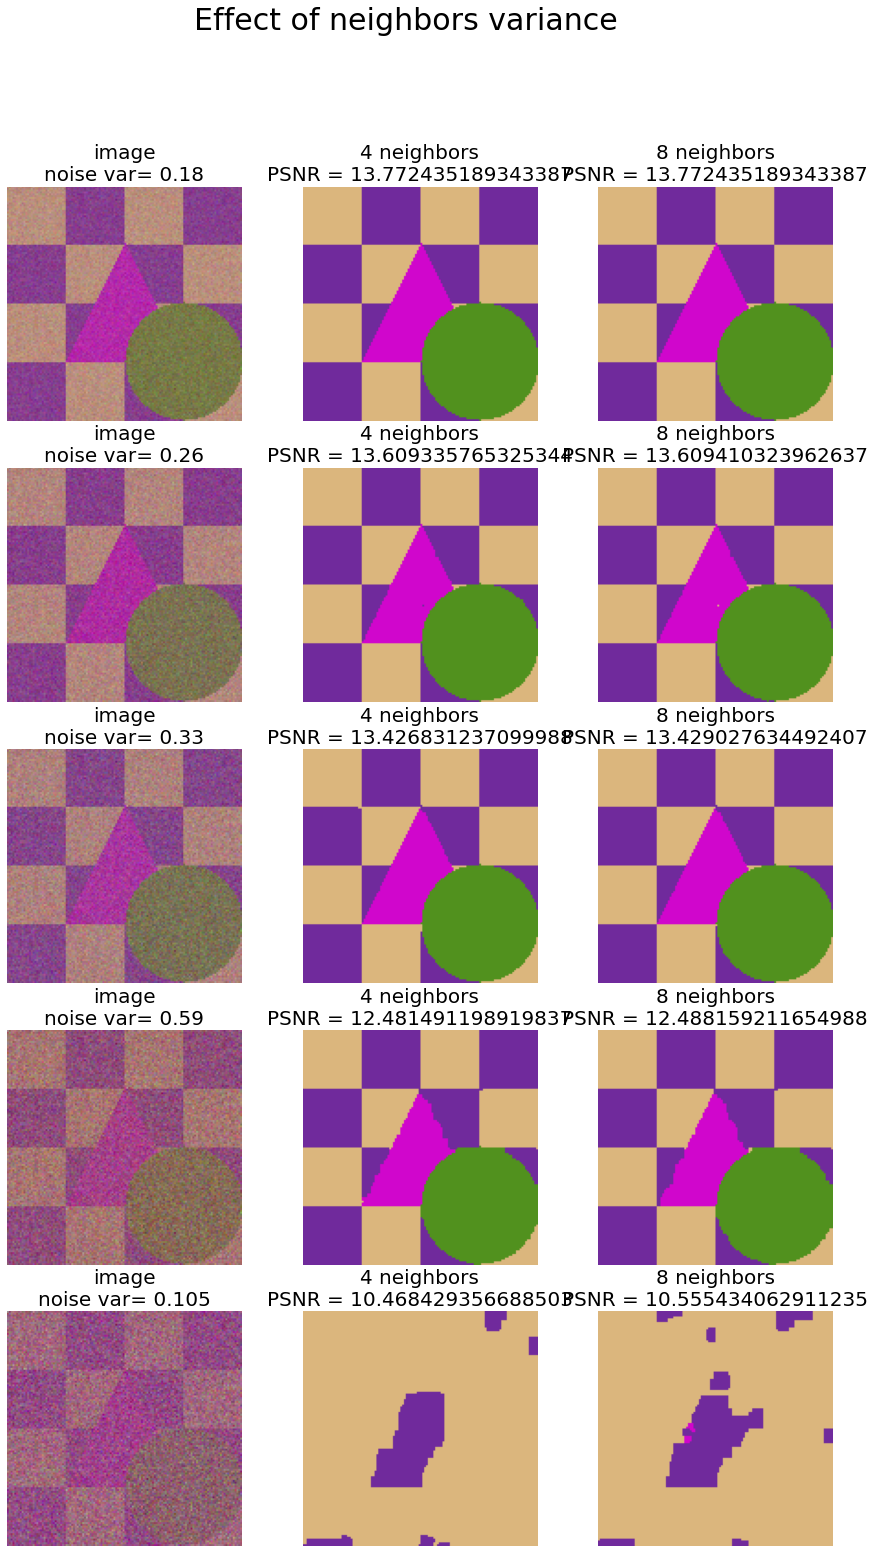

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig, axs = plt.subplots(len(N4Noises),3, figsize=(15,5*len(N4Noises)))
fig.suptitle("Effect of neighbors variance", fontsize=30)
for i in range(len(N4Noises)):
    img = '../input/color_'+str(N4Noises[i])+'.bmp'
    axs[i][0].imshow(mpimg.imread(img))
    axs[i][0].axis("off")
    axs[i][0].set_title('image\n'+'noise var= 0.'+str(N4Noises[i]), fontsize=20)
    axs[i][1].imshow(N4OutImageList[i])
    axs[i][1].axis("off")
    psnr = N4PSNRList[i]
    axs[i][1].set_title('4 neighbors\n' + 'PSNR = '+str(psnr), fontsize=20)
    axs[i][2].imshow(N8OutImageList[i])
    axs[i][2].axis("off")
    psnr = N8PSNRList[i]
    axs[i][2].set_title('8 neighbors\n' + 'PSNR = '+str(psnr), fontsize=20)
#plt.tight_layout()
plt.show()

## Temperature

In [21]:
import time
TempNoises = [18]
TempOutImageList = []
TempWholeEnergyList = []
TempWholeTList = []
TempPSNRList = []
TempList = [0.0001, 10, 100, 1000, 1000000000] #4
beta = 2.5
c=0.98
threshold=0.05
for k in range(len(TempList)):
    start_time = time.time()
    
    mean = np.zeros([no_regions,3]).astype("float64")
    variance = np.zeros([no_regions, 3]).astype("float64")
    covariance = np.zeros([no_regions, 3]).astype("float64")
    invcov = np.zeros([no_regions, 6]).astype("float64")
    denom = np.zeros([no_regions]).astype("float64")
    
    img = '../input/color_'+str(TempNoises[0])+'.bmp'
    print(img)
    OriImg = cv2.imread(img)
    img = cv2.cvtColor(OriImg, cv2.COLOR_RGB2BGR)
    img1 = img.astype('float64')
    img3 = RGB2Luv(img1)
    points = np.array([[(0,0),(4,4)],[(32,0),(36,4)],[(64,64),(68,68)],[(96,96),(100,100)]])
    i=0
    for refPoint in points:
        frame_i = img3[refPoint[0][1]:refPoint[1][1], refPoint[0][0]:refPoint[1][0]]
        mean[i], variance[i], covariance[i], invcov[i], denom[i] = CalculateMeanAndCovariance(frame_i)
        i+=1
    mean=(mean.T)
    variance=(variance.T)
    covariance=(covariance.T)
    invcov=(invcov.T)
    denom=(denom.T)
    classes, wholeEnergy, wholeT=gibbs(img3, mean, variance, covariance, invcov, denom, beta, TempList[i], c, threshold)
    timespent=(time.time()-start_time)/len(wholeEnergy)
    print(["PSNR:"+str(psnr)])
    print(["Average time:"+str(timespent)])
    OutImage=outConvert(classes)
    psnr = cv2.PSNR(OriImg, OutImage.astype('uint8'))
    TempPSNRList.append(psnr)
    TempOutImageList.append(OutImage)
    TempWholeEnergyList.append(wholeEnergy)
    TempWholeTList.append(wholeT)
    

../input/color_18.bmp
T: 980000000.0
iterNo: 1
T: 960400000.0
iterNo: 2
T: 941192000.0
iterNo: 3
T: 922368160.0
iterNo: 4
T: 903920796.8
iterNo: 5
T: 885842380.864
iterNo: 6
T: 868125533.24672
iterNo: 7
T: 850763022.5817856
iterNo: 8
T: 833747762.1301498
iterNo: 9
T: 817072806.8875468
iterNo: 10
T: 800731350.7497958
iterNo: 11
T: 784716723.7347999
iterNo: 12
T: 769022389.2601038
iterNo: 13
T: 753641941.4749017
iterNo: 14
T: 738569102.6454036
iterNo: 15
T: 723797720.5924956
iterNo: 16
T: 709321766.1806456
iterNo: 17
T: 695135330.8570327
iterNo: 18
T: 681232624.239892
iterNo: 19
T: 667607971.7550942
iterNo: 20
T: 654255812.3199923
iterNo: 21
T: 641170696.0735924
iterNo: 22
T: 628347282.1521206
iterNo: 23
T: 615780336.5090781
iterNo: 24
T: 603464729.7788966
iterNo: 25
T: 591395435.1833186
iterNo: 26
T: 579567526.4796523
iterNo: 27
T: 567976175.9500592
iterNo: 28
T: 556616652.4310579
iterNo: 29
T: 545484319.3824368
iterNo: 30
T: 534574632.994788
iterNo: 31
T: 523883140.3348922
iterNo: 32
T

T: 6276896.951018989
iterNo: 251
T: 6151359.01199861
iterNo: 252
T: 6028331.831758637
iterNo: 253
T: 5907765.195123464
iterNo: 254
T: 5789609.891220994
iterNo: 255
T: 5673817.693396574
iterNo: 256
T: 5560341.339528643
iterNo: 257
T: 5449134.5127380695
iterNo: 258
T: 5340151.822483308
iterNo: 259
T: 5233348.786033642
iterNo: 260
T: 5128681.810312969
iterNo: 261
T: 5026108.17410671
iterNo: 262
T: 4925586.010624575
iterNo: 263
T: 4827074.290412084
iterNo: 264
T: 4730532.804603842
iterNo: 265
T: 4635922.1485117655
iterNo: 266
T: 4543203.70554153
iterNo: 267
T: 4452339.631430699
iterNo: 268
T: 4363292.838802084
iterNo: 269
T: 4276026.982026042
iterNo: 270
T: 4190506.4423855217
iterNo: 271
T: 4106696.3135378114
iterNo: 272
T: 4024562.387267055
iterNo: 273
T: 3944071.139521714
iterNo: 274
T: 3865189.7167312796
iterNo: 275
T: 3787885.922396654
iterNo: 276
T: 3712128.203948721
iterNo: 277
T: 3637885.6398697463
iterNo: 278
T: 3565127.9270723513
iterNo: 279
T: 3493825.3685309044
iterNo: 280
T: 34

T: 43587.26502719128
iterNo: 497
T: 42715.51972664745
iterNo: 498
T: 41861.2093321145
iterNo: 499
T: 41023.98514547221
iterNo: 500
T: 40203.50544256276
iterNo: 501
T: 39399.4353337115
iterNo: 502
T: 38611.44662703727
iterNo: 503
T: 37839.217694496525
iterNo: 504
T: 37082.43334060659
iterNo: 505
T: 36340.78467379446
iterNo: 506
T: 35613.96898031857
iterNo: 507
T: 34901.6896007122
iterNo: 508
T: 34203.65580869796
iterNo: 509
T: 33519.582692523996
iterNo: 510
T: 32849.19103867352
iterNo: 511
T: 32192.207217900046
iterNo: 512
T: 31548.363073542045
iterNo: 513
T: 30917.395812071205
iterNo: 514
T: 30299.04789582978
iterNo: 515
T: 29693.066937913183
iterNo: 516
T: 29099.20559915492
iterNo: 517
T: 28517.22148717182
iterNo: 518
T: 27946.877057428384
iterNo: 519
T: 27387.939516279817
iterNo: 520
T: 26840.180725954222
iterNo: 521
T: 26303.377111435137
iterNo: 522
T: 25777.309569206434
iterNo: 523
T: 25261.763377822306
iterNo: 524
T: 24756.52811026586
iterNo: 525
T: 24261.39754806054
iterNo: 526
T

T: 302.6733889971205
iterNo: 743
T: 296.6199212171781
iterNo: 744
T: 290.68752279283456
iterNo: 745
T: 284.8737723369779
iterNo: 746
T: 279.1762968902383
iterNo: 747
T: 273.5927709524335
iterNo: 748
T: 268.12091553338485
iterNo: 749
T: 262.75849722271715
iterNo: 750
T: 257.5033272782628
iterNo: 751
T: 252.35326073269755
iterNo: 752
T: 247.30619551804358
iterNo: 753
T: 242.3600716076827
iterNo: 754
T: 237.51287017552903
iterNo: 755
T: 232.76261277201846
iterNo: 756
T: 228.1073605165781
iterNo: 757
T: 223.54521330624652
iterNo: 758
T: 219.0743090401216
iterNo: 759
T: 214.69282285931916
iterNo: 760
T: 210.39896640213277
iterNo: 761
T: 206.19098707409012
iterNo: 762
T: 202.0671673326083
iterNo: 763
T: 198.02582398595612
iterNo: 764
T: 194.065307506237
iterNo: 765
T: 190.18400135611225
iterNo: 766
T: 186.38032132899
iterNo: 767
T: 182.6527149024102
iterNo: 768
T: 178.999660604362
iterNo: 769
T: 175.41966739227476
iterNo: 770
T: 171.91127404442926
iterNo: 771
T: 168.4730485635407
iterNo: 772

T: 868125533.24672
iterNo: 7
T: 850763022.5817856
iterNo: 8
T: 833747762.1301498
iterNo: 9
T: 817072806.8875468
iterNo: 10
T: 800731350.7497958
iterNo: 11
T: 784716723.7347999
iterNo: 12
T: 769022389.2601038
iterNo: 13
T: 753641941.4749017
iterNo: 14
T: 738569102.6454036
iterNo: 15
T: 723797720.5924956
iterNo: 16
T: 709321766.1806456
iterNo: 17
T: 695135330.8570327
iterNo: 18
T: 681232624.239892
iterNo: 19
T: 667607971.7550942
iterNo: 20
T: 654255812.3199923
iterNo: 21
T: 641170696.0735924
iterNo: 22
T: 628347282.1521206
iterNo: 23
T: 615780336.5090781
iterNo: 24
T: 603464729.7788966
iterNo: 25
T: 591395435.1833186
iterNo: 26
T: 579567526.4796523
iterNo: 27
T: 567976175.9500592
iterNo: 28
T: 556616652.4310579
iterNo: 29
T: 545484319.3824368
iterNo: 30
T: 534574632.994788
iterNo: 31
T: 523883140.3348922
iterNo: 32
T: 513405477.52819437
iterNo: 33
T: 503137367.9776305
iterNo: 34
T: 493074620.6180779
iterNo: 35
T: 483213128.2057163
iterNo: 36
T: 473548865.641602
iterNo: 37
T: 464077888.32

T: 5673817.693396574
iterNo: 256
T: 5560341.339528643
iterNo: 257
T: 5449134.5127380695
iterNo: 258
T: 5340151.822483308
iterNo: 259
T: 5233348.786033642
iterNo: 260
T: 5128681.810312969
iterNo: 261
T: 5026108.17410671
iterNo: 262
T: 4925586.010624575
iterNo: 263
T: 4827074.290412084
iterNo: 264
T: 4730532.804603842
iterNo: 265
T: 4635922.1485117655
iterNo: 266
T: 4543203.70554153
iterNo: 267
T: 4452339.631430699
iterNo: 268
T: 4363292.838802084
iterNo: 269
T: 4276026.982026042
iterNo: 270
T: 4190506.4423855217
iterNo: 271
T: 4106696.3135378114
iterNo: 272
T: 4024562.387267055
iterNo: 273
T: 3944071.139521714
iterNo: 274
T: 3865189.7167312796
iterNo: 275
T: 3787885.922396654
iterNo: 276
T: 3712128.203948721
iterNo: 277
T: 3637885.6398697463
iterNo: 278
T: 3565127.9270723513
iterNo: 279
T: 3493825.3685309044
iterNo: 280
T: 3423948.8611602862
iterNo: 281
T: 3355469.8839370804
iterNo: 282
T: 3288360.4862583387
iterNo: 283
T: 3222593.276533172
iterNo: 284
T: 3158141.4110025084
iterNo: 285


T: 39399.4353337115
iterNo: 502
T: 38611.44662703727
iterNo: 503
T: 37839.217694496525
iterNo: 504
T: 37082.43334060659
iterNo: 505
T: 36340.78467379446
iterNo: 506
T: 35613.96898031857
iterNo: 507
T: 34901.6896007122
iterNo: 508
T: 34203.65580869796
iterNo: 509
T: 33519.582692523996
iterNo: 510
T: 32849.19103867352
iterNo: 511
T: 32192.207217900046
iterNo: 512
T: 31548.363073542045
iterNo: 513
T: 30917.395812071205
iterNo: 514
T: 30299.04789582978
iterNo: 515
T: 29693.066937913183
iterNo: 516
T: 29099.20559915492
iterNo: 517
T: 28517.22148717182
iterNo: 518
T: 27946.877057428384
iterNo: 519
T: 27387.939516279817
iterNo: 520
T: 26840.180725954222
iterNo: 521
T: 26303.377111435137
iterNo: 522
T: 25777.309569206434
iterNo: 523
T: 25261.763377822306
iterNo: 524
T: 24756.52811026586
iterNo: 525
T: 24261.39754806054
iterNo: 526
T: 23776.169597099328
iterNo: 527
T: 23300.64620515734
iterNo: 528
T: 22834.633281054194
iterNo: 529
T: 22377.940615433108
iterNo: 530
T: 21930.381803124445
iterNo: 

T: 273.5927709524335
iterNo: 748
T: 268.12091553338485
iterNo: 749
T: 262.75849722271715
iterNo: 750
T: 257.5033272782628
iterNo: 751
T: 252.35326073269755
iterNo: 752
T: 247.30619551804358
iterNo: 753
T: 242.3600716076827
iterNo: 754
T: 237.51287017552903
iterNo: 755
T: 232.76261277201846
iterNo: 756
T: 228.1073605165781
iterNo: 757
T: 223.54521330624652
iterNo: 758
T: 219.0743090401216
iterNo: 759
T: 214.69282285931916
iterNo: 760
T: 210.39896640213277
iterNo: 761
T: 206.19098707409012
iterNo: 762
T: 202.0671673326083
iterNo: 763
T: 198.02582398595612
iterNo: 764
T: 194.065307506237
iterNo: 765
T: 190.18400135611225
iterNo: 766
T: 186.38032132899
iterNo: 767
T: 182.6527149024102
iterNo: 768
T: 178.999660604362
iterNo: 769
T: 175.41966739227476
iterNo: 770
T: 171.91127404442926
iterNo: 771
T: 168.4730485635407
iterNo: 772
T: 165.10358759226986
iterNo: 773
T: 161.80151584042446
iterNo: 774
T: 158.56548552361596
iterNo: 775
T: 155.39417581314365
iterNo: 776
T: 152.28629229688076
iterNo:

T: 738569102.6454036
iterNo: 15
T: 723797720.5924956
iterNo: 16
T: 709321766.1806456
iterNo: 17
T: 695135330.8570327
iterNo: 18
T: 681232624.239892
iterNo: 19
T: 667607971.7550942
iterNo: 20
T: 654255812.3199923
iterNo: 21
T: 641170696.0735924
iterNo: 22
T: 628347282.1521206
iterNo: 23
T: 615780336.5090781
iterNo: 24
T: 603464729.7788966
iterNo: 25
T: 591395435.1833186
iterNo: 26
T: 579567526.4796523
iterNo: 27
T: 567976175.9500592
iterNo: 28
T: 556616652.4310579
iterNo: 29
T: 545484319.3824368
iterNo: 30
T: 534574632.994788
iterNo: 31
T: 523883140.3348922
iterNo: 32
T: 513405477.52819437
iterNo: 33
T: 503137367.9776305
iterNo: 34
T: 493074620.6180779
iterNo: 35
T: 483213128.2057163
iterNo: 36
T: 473548865.641602
iterNo: 37
T: 464077888.3287699
iterNo: 38
T: 454796330.5621945
iterNo: 39
T: 445700403.9509506
iterNo: 40
T: 436786395.8719316
iterNo: 41
T: 428050667.954493
iterNo: 42
T: 419489654.59540313
iterNo: 43
T: 411099861.50349504
iterNo: 44
T: 402877864.2734251
iterNo: 45
T: 394820

T: 4827074.290412084
iterNo: 264
T: 4730532.804603842
iterNo: 265
T: 4635922.1485117655
iterNo: 266
T: 4543203.70554153
iterNo: 267
T: 4452339.631430699
iterNo: 268
T: 4363292.838802084
iterNo: 269
T: 4276026.982026042
iterNo: 270
T: 4190506.4423855217
iterNo: 271
T: 4106696.3135378114
iterNo: 272
T: 4024562.387267055
iterNo: 273
T: 3944071.139521714
iterNo: 274
T: 3865189.7167312796
iterNo: 275
T: 3787885.922396654
iterNo: 276
T: 3712128.203948721
iterNo: 277
T: 3637885.6398697463
iterNo: 278
T: 3565127.9270723513
iterNo: 279
T: 3493825.3685309044
iterNo: 280
T: 3423948.8611602862
iterNo: 281
T: 3355469.8839370804
iterNo: 282
T: 3288360.4862583387
iterNo: 283
T: 3222593.276533172
iterNo: 284
T: 3158141.4110025084
iterNo: 285
T: 3094978.582782458
iterNo: 286
T: 3033079.011126809
iterNo: 287
T: 2972417.4309042725
iterNo: 288
T: 2912969.082286187
iterNo: 289
T: 2854709.7006404633
iterNo: 290
T: 2797615.5066276537
iterNo: 291
T: 2741663.1964951004
iterNo: 292
T: 2686829.9325651983
iterNo:

T: 33519.582692523996
iterNo: 510
T: 32849.19103867352
iterNo: 511
T: 32192.207217900046
iterNo: 512
T: 31548.363073542045
iterNo: 513
T: 30917.395812071205
iterNo: 514
T: 30299.04789582978
iterNo: 515
T: 29693.066937913183
iterNo: 516
T: 29099.20559915492
iterNo: 517
T: 28517.22148717182
iterNo: 518
T: 27946.877057428384
iterNo: 519
T: 27387.939516279817
iterNo: 520
T: 26840.180725954222
iterNo: 521
T: 26303.377111435137
iterNo: 522
T: 25777.309569206434
iterNo: 523
T: 25261.763377822306
iterNo: 524
T: 24756.52811026586
iterNo: 525
T: 24261.39754806054
iterNo: 526
T: 23776.169597099328
iterNo: 527
T: 23300.64620515734
iterNo: 528
T: 22834.633281054194
iterNo: 529
T: 22377.940615433108
iterNo: 530
T: 21930.381803124445
iterNo: 531
T: 21491.774167061954
iterNo: 532
T: 21061.938683720717
iterNo: 533
T: 20640.699910046304
iterNo: 534
T: 20227.885911845377
iterNo: 535
T: 19823.328193608468
iterNo: 536
T: 19426.861629736297
iterNo: 537
T: 19038.324397141572
iterNo: 538
T: 18657.557909198742

T: 232.76261277201846
iterNo: 756
T: 228.1073605165781
iterNo: 757
T: 223.54521330624652
iterNo: 758
T: 219.0743090401216
iterNo: 759
T: 214.69282285931916
iterNo: 760
T: 210.39896640213277
iterNo: 761
T: 206.19098707409012
iterNo: 762
T: 202.0671673326083
iterNo: 763
T: 198.02582398595612
iterNo: 764
T: 194.065307506237
iterNo: 765
T: 190.18400135611225
iterNo: 766
T: 186.38032132899
iterNo: 767
T: 182.6527149024102
iterNo: 768
T: 178.999660604362
iterNo: 769
T: 175.41966739227476
iterNo: 770
T: 171.91127404442926
iterNo: 771
T: 168.4730485635407
iterNo: 772
T: 165.10358759226986
iterNo: 773
T: 161.80151584042446
iterNo: 774
T: 158.56548552361596
iterNo: 775
T: 155.39417581314365
iterNo: 776
T: 152.28629229688076
iterNo: 777
T: 149.24056645094313
iterNo: 778
T: 146.25575512192427
iterNo: 779
T: 143.33064001948577
iterNo: 780
T: 140.46402721909604
iterNo: 781
T: 137.65474667471412
iterNo: 782
T: 134.90165174121984
iterNo: 783
T: 132.20361870639545
iterNo: 784
T: 129.55954633226753
iter

T: 615780336.5090781
iterNo: 24
T: 603464729.7788966
iterNo: 25
T: 591395435.1833186
iterNo: 26
T: 579567526.4796523
iterNo: 27
T: 567976175.9500592
iterNo: 28
T: 556616652.4310579
iterNo: 29
T: 545484319.3824368
iterNo: 30
T: 534574632.994788
iterNo: 31
T: 523883140.3348922
iterNo: 32
T: 513405477.52819437
iterNo: 33
T: 503137367.9776305
iterNo: 34
T: 493074620.6180779
iterNo: 35
T: 483213128.2057163
iterNo: 36
T: 473548865.641602
iterNo: 37
T: 464077888.3287699
iterNo: 38
T: 454796330.5621945
iterNo: 39
T: 445700403.9509506
iterNo: 40
T: 436786395.8719316
iterNo: 41
T: 428050667.954493
iterNo: 42
T: 419489654.59540313
iterNo: 43
T: 411099861.50349504
iterNo: 44
T: 402877864.2734251
iterNo: 45
T: 394820306.9879566
iterNo: 46
T: 386923900.84819746
iterNo: 47
T: 379185422.8312335
iterNo: 48
T: 371601714.3746088
iterNo: 49
T: 364169680.08711666
iterNo: 50
T: 356886286.48537433
iterNo: 51
T: 349748560.75566685
iterNo: 52
T: 342753589.5405535
iterNo: 53
T: 335898517.74974245
iterNo: 54
T: 

T: 4106696.3135378114
iterNo: 272
T: 4024562.387267055
iterNo: 273
T: 3944071.139521714
iterNo: 274
T: 3865189.7167312796
iterNo: 275
T: 3787885.922396654
iterNo: 276
T: 3712128.203948721
iterNo: 277
T: 3637885.6398697463
iterNo: 278
T: 3565127.9270723513
iterNo: 279
T: 3493825.3685309044
iterNo: 280
T: 3423948.8611602862
iterNo: 281
T: 3355469.8839370804
iterNo: 282
T: 3288360.4862583387
iterNo: 283
T: 3222593.276533172
iterNo: 284
T: 3158141.4110025084
iterNo: 285
T: 3094978.582782458
iterNo: 286
T: 3033079.011126809
iterNo: 287
T: 2972417.4309042725
iterNo: 288
T: 2912969.082286187
iterNo: 289
T: 2854709.7006404633
iterNo: 290
T: 2797615.5066276537
iterNo: 291
T: 2741663.1964951004
iterNo: 292
T: 2686829.9325651983
iterNo: 293
T: 2633093.3339138944
iterNo: 294
T: 2580431.4672356164
iterNo: 295
T: 2528822.837890904
iterNo: 296
T: 2478246.3811330856
iterNo: 297
T: 2428681.4535104237
iterNo: 298
T: 2380107.8244402152
iterNo: 299
T: 2332505.667951411
iterNo: 300
T: 2285855.5545923826
it

T: 28517.22148717182
iterNo: 518
T: 27946.877057428384
iterNo: 519
T: 27387.939516279817
iterNo: 520
T: 26840.180725954222
iterNo: 521
T: 26303.377111435137
iterNo: 522
T: 25777.309569206434
iterNo: 523
T: 25261.763377822306
iterNo: 524
T: 24756.52811026586
iterNo: 525
T: 24261.39754806054
iterNo: 526
T: 23776.169597099328
iterNo: 527
T: 23300.64620515734
iterNo: 528
T: 22834.633281054194
iterNo: 529
T: 22377.940615433108
iterNo: 530
T: 21930.381803124445
iterNo: 531
T: 21491.774167061954
iterNo: 532
T: 21061.938683720717
iterNo: 533
T: 20640.699910046304
iterNo: 534
T: 20227.885911845377
iterNo: 535
T: 19823.328193608468
iterNo: 536
T: 19426.861629736297
iterNo: 537
T: 19038.324397141572
iterNo: 538
T: 18657.557909198742
iterNo: 539
T: 18284.406751014765
iterNo: 540
T: 17918.71861599447
iterNo: 541
T: 17560.34424367458
iterNo: 542
T: 17209.137358801087
iterNo: 543
T: 16864.954611625064
iterNo: 544
T: 16527.655519392563
iterNo: 545
T: 16197.102409004712
iterNo: 546
T: 15873.16036082461

T: 198.02582398595612
iterNo: 764
T: 194.065307506237
iterNo: 765
T: 190.18400135611225
iterNo: 766
T: 186.38032132899
iterNo: 767
T: 182.6527149024102
iterNo: 768
T: 178.999660604362
iterNo: 769
T: 175.41966739227476
iterNo: 770
T: 171.91127404442926
iterNo: 771
T: 168.4730485635407
iterNo: 772
T: 165.10358759226986
iterNo: 773
T: 161.80151584042446
iterNo: 774
T: 158.56548552361596
iterNo: 775
T: 155.39417581314365
iterNo: 776
T: 152.28629229688076
iterNo: 777
T: 149.24056645094313
iterNo: 778
T: 146.25575512192427
iterNo: 779
T: 143.33064001948577
iterNo: 780
T: 140.46402721909604
iterNo: 781
T: 137.65474667471412
iterNo: 782
T: 134.90165174121984
iterNo: 783
T: 132.20361870639545
iterNo: 784
T: 129.55954633226753
iterNo: 785
T: 126.96835540562218
iterNo: 786
T: 124.42898829750973
iterNo: 787
T: 121.94040853155954
iterNo: 788
T: 119.50160036092835
iterNo: 789
T: 117.11156835370979
iterNo: 790
T: 114.7693369866356
iterNo: 791
T: 112.47395024690287
iterNo: 792
T: 110.22447124196482
it

T: 591395435.1833186
iterNo: 26
T: 579567526.4796523
iterNo: 27
T: 567976175.9500592
iterNo: 28
T: 556616652.4310579
iterNo: 29
T: 545484319.3824368
iterNo: 30
T: 534574632.994788
iterNo: 31
T: 523883140.3348922
iterNo: 32
T: 513405477.52819437
iterNo: 33
T: 503137367.9776305
iterNo: 34
T: 493074620.6180779
iterNo: 35
T: 483213128.2057163
iterNo: 36
T: 473548865.641602
iterNo: 37
T: 464077888.3287699
iterNo: 38
T: 454796330.5621945
iterNo: 39
T: 445700403.9509506
iterNo: 40
T: 436786395.8719316
iterNo: 41
T: 428050667.954493
iterNo: 42
T: 419489654.59540313
iterNo: 43
T: 411099861.50349504
iterNo: 44
T: 402877864.2734251
iterNo: 45
T: 394820306.9879566
iterNo: 46
T: 386923900.84819746
iterNo: 47
T: 379185422.8312335
iterNo: 48
T: 371601714.3746088
iterNo: 49
T: 364169680.08711666
iterNo: 50
T: 356886286.48537433
iterNo: 51
T: 349748560.75566685
iterNo: 52
T: 342753589.5405535
iterNo: 53
T: 335898517.74974245
iterNo: 54
T: 329180547.3947476
iterNo: 55
T: 322596936.4468527
iterNo: 56
T: 

T: 3944071.139521714
iterNo: 274
T: 3865189.7167312796
iterNo: 275
T: 3787885.922396654
iterNo: 276
T: 3712128.203948721
iterNo: 277
T: 3637885.6398697463
iterNo: 278
T: 3565127.9270723513
iterNo: 279
T: 3493825.3685309044
iterNo: 280
T: 3423948.8611602862
iterNo: 281
T: 3355469.8839370804
iterNo: 282
T: 3288360.4862583387
iterNo: 283
T: 3222593.276533172
iterNo: 284
T: 3158141.4110025084
iterNo: 285
T: 3094978.582782458
iterNo: 286
T: 3033079.011126809
iterNo: 287
T: 2972417.4309042725
iterNo: 288
T: 2912969.082286187
iterNo: 289
T: 2854709.7006404633
iterNo: 290
T: 2797615.5066276537
iterNo: 291
T: 2741663.1964951004
iterNo: 292
T: 2686829.9325651983
iterNo: 293
T: 2633093.3339138944
iterNo: 294
T: 2580431.4672356164
iterNo: 295
T: 2528822.837890904
iterNo: 296
T: 2478246.3811330856
iterNo: 297
T: 2428681.4535104237
iterNo: 298
T: 2380107.8244402152
iterNo: 299
T: 2332505.667951411
iterNo: 300
T: 2285855.5545923826
iterNo: 301
T: 2240138.443500535
iterNo: 302
T: 2195335.674630524
ite

T: 27387.939516279817
iterNo: 520
T: 26840.180725954222
iterNo: 521
T: 26303.377111435137
iterNo: 522
T: 25777.309569206434
iterNo: 523
T: 25261.763377822306
iterNo: 524
T: 24756.52811026586
iterNo: 525
T: 24261.39754806054
iterNo: 526
T: 23776.169597099328
iterNo: 527
T: 23300.64620515734
iterNo: 528
T: 22834.633281054194
iterNo: 529
T: 22377.940615433108
iterNo: 530
T: 21930.381803124445
iterNo: 531
T: 21491.774167061954
iterNo: 532
T: 21061.938683720717
iterNo: 533
T: 20640.699910046304
iterNo: 534
T: 20227.885911845377
iterNo: 535
T: 19823.328193608468
iterNo: 536
T: 19426.861629736297
iterNo: 537
T: 19038.324397141572
iterNo: 538
T: 18657.557909198742
iterNo: 539
T: 18284.406751014765
iterNo: 540
T: 17918.71861599447
iterNo: 541
T: 17560.34424367458
iterNo: 542
T: 17209.137358801087
iterNo: 543
T: 16864.954611625064
iterNo: 544
T: 16527.655519392563
iterNo: 545
T: 16197.102409004712
iterNo: 546
T: 15873.160360824617
iterNo: 547
T: 15555.697153608124
iterNo: 548
T: 15244.5832105359

T: 190.18400135611225
iterNo: 766
T: 186.38032132899
iterNo: 767
T: 182.6527149024102
iterNo: 768
T: 178.999660604362
iterNo: 769
T: 175.41966739227476
iterNo: 770
T: 171.91127404442926
iterNo: 771
T: 168.4730485635407
iterNo: 772
T: 165.10358759226986
iterNo: 773
T: 161.80151584042446
iterNo: 774
T: 158.56548552361596
iterNo: 775
T: 155.39417581314365
iterNo: 776
T: 152.28629229688076
iterNo: 777
T: 149.24056645094313
iterNo: 778
T: 146.25575512192427
iterNo: 779
T: 143.33064001948577
iterNo: 780
T: 140.46402721909604
iterNo: 781
T: 137.65474667471412
iterNo: 782
T: 134.90165174121984
iterNo: 783
T: 132.20361870639545
iterNo: 784
T: 129.55954633226753
iterNo: 785
T: 126.96835540562218
iterNo: 786
T: 124.42898829750973
iterNo: 787
T: 121.94040853155954
iterNo: 788
T: 119.50160036092835
iterNo: 789
T: 117.11156835370979
iterNo: 790
T: 114.7693369866356
iterNo: 791
T: 112.47395024690287
iterNo: 792
T: 110.22447124196482
iterNo: 793
T: 108.01998181712553
iterNo: 794
T: 105.85958218078301


In [22]:
print(TempPSNRList)

[13.772435189343387, 13.772485717493678, 13.772541687823331, 13.772435189343387, 13.772435189343387]


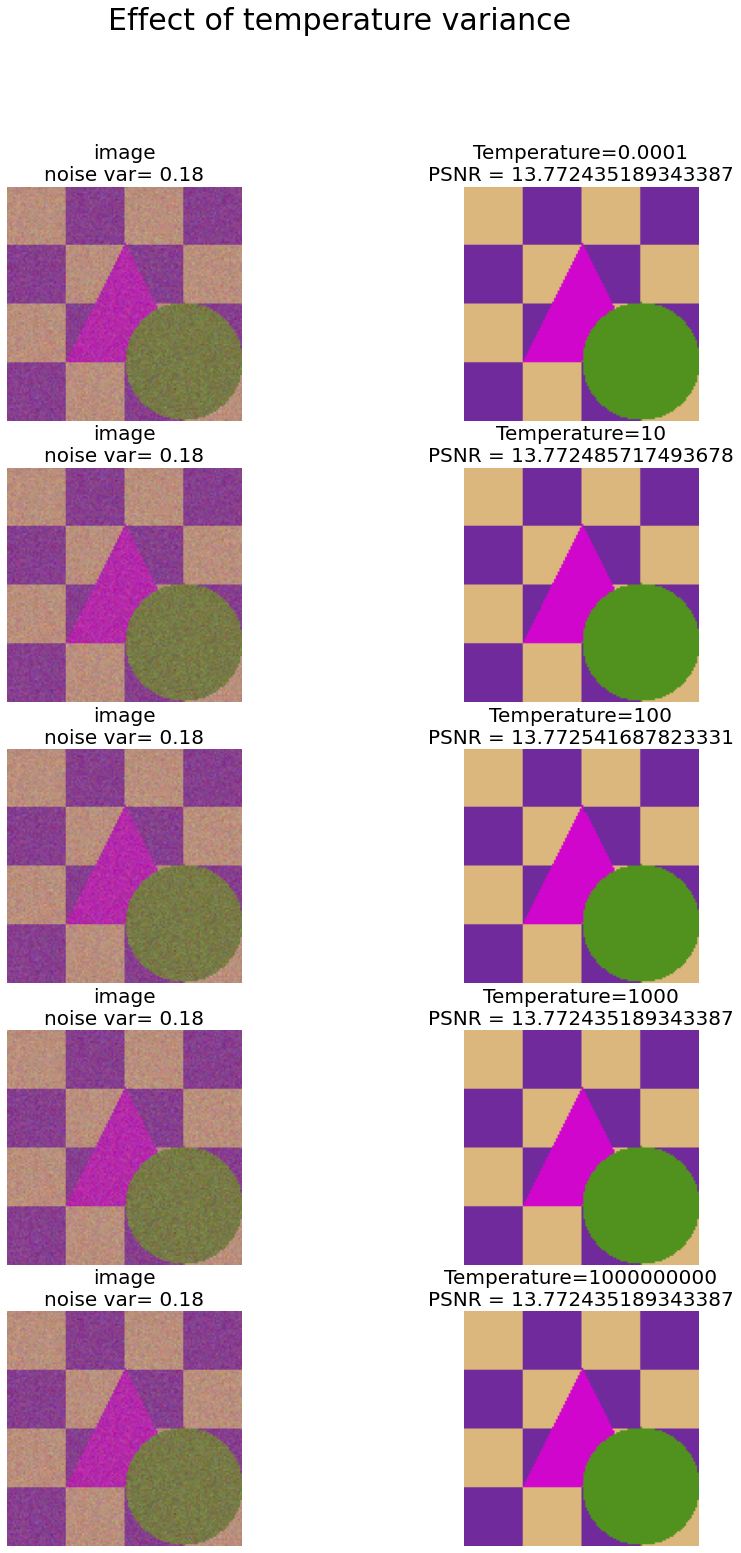

In [23]:
fig, axs = plt.subplots(len(TempList),2, figsize=(15,5*len(TempList)))
fig.suptitle("Effect of temperature variance", fontsize=30)
for i in range(len(TempList)):
    img = '../input/color_'+str(TempNoises[0])+'.bmp'
    psnr = TempPSNRList[i]
    axs[i][0].imshow(mpimg.imread(img))
    axs[i][0].axis("off")
    axs[i][0].set_title('image\n'+'noise var= 0.'+str(TempNoises[0]), fontsize=20)
    axs[i][1].imshow(TempOutImageList[i])
    axs[i][1].axis("off")
    axs[i][1].set_title('Temperature='+str(TempList[i])+'\n' + 'PSNR = '+str(psnr), fontsize=20)
#plt.tight_layout()
plt.show()

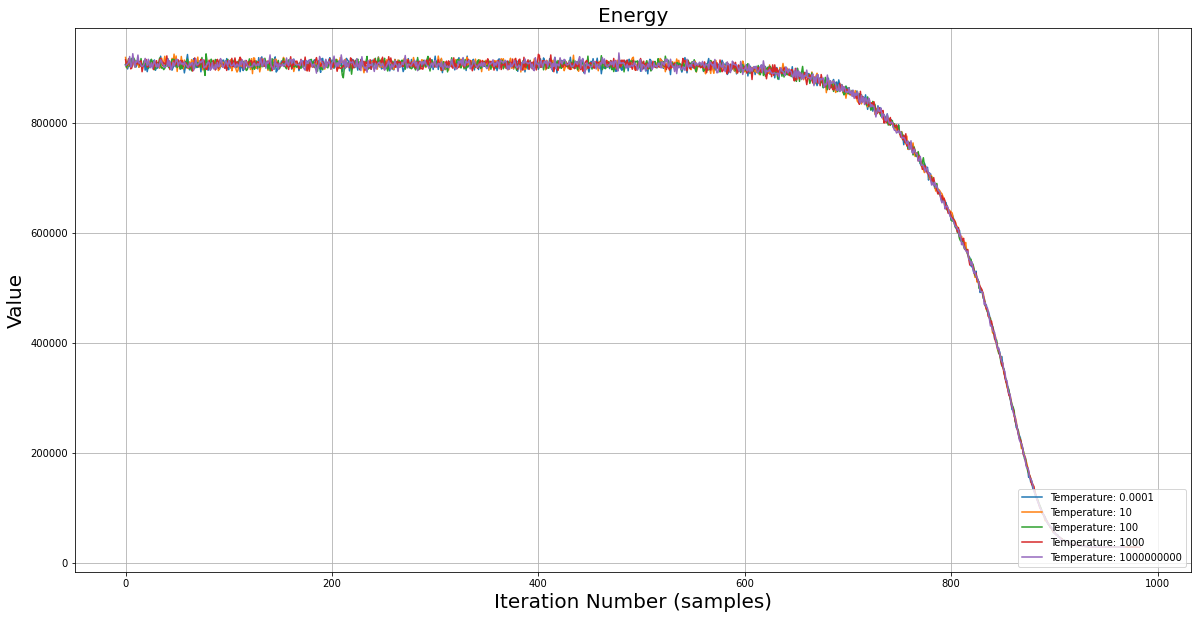

In [24]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Energy', fontsize=20)
ax1.set_xlabel("Iteration Number (samples)", fontsize=20)
ax1.set_ylabel("Value",fontsize=20)

for i in range(len(TempList)):
    plt.plot(TempWholeEnergyList[i], label="Temperature: "+str(TempList[i]))
ax1.legend(loc=4)
ax1.grid()
plt.show()
fig.savefig("energy_temperature_4_labels.png")

## Temperature Ratio

In [ ]:
import time
RatioNoises = [33]
RatioOutImageList = []
RatioWholeEnergyList = []
RatioWholeTList = []
RatioPSNRList = []
beta = 2.5
T0 = 100
TempRatioList=[0.5, 0.75, 0.98, 1]
threshold=0.05
for k in range(len(TempRatioList)):
    start_time = time.time()
    
    mean = np.zeros([no_regions,3]).astype("float64")
    variance = np.zeros([no_regions, 3]).astype("float64")
    covariance = np.zeros([no_regions, 3]).astype("float64")
    invcov = np.zeros([no_regions, 6]).astype("float64")
    denom = np.zeros([no_regions]).astype("float64")
    
    img = '../input/color_'+str(RatioNoises[0])+'.bmp'
    print(img)
    OriImg = cv2.imread(img)
    img = cv2.cvtColor(OriImg, cv2.COLOR_RGB2BGR)
    img1 = img.astype('float64')
    img3 = RGB2Luv(img1)
    points = np.array([[(0,0),(4,4)],[(32,0),(36,4)],[(64,64),(68,68)],[(96,96),(100,100)]])
    i=0
    for refPoint in points:
        frame_i = img3[refPoint[0][1]:refPoint[1][1], refPoint[0][0]:refPoint[1][0]]
        mean[i], variance[i], covariance[i], invcov[i], denom[i] = CalculateMeanAndCovariance(frame_i)
        i+=1
    mean=(mean.T)
    variance=(variance.T)
    covariance=(covariance.T)
    invcov=(invcov.T)
    denom=(denom.T)
    classes, wholeEnergy, wholeT=gibbs(img3, mean, variance, covariance, invcov, denom, beta, T0, TempRatioList[k], threshold)
    timespent=(time.time()-start_time)/len(wholeEnergy)
    print(["PSNR:"+str(psnr)])
    print(["Average time:"+str(timespent)])
    OutImage=outConvert(classes)
    psnr = cv2.PSNR(OriImg, OutImage.astype('uint8'))
    RatioPSNRList.append(psnr)
    RatioOutImageList.append(OutImage)
    RatioWholeEnergyList.append(wholeEnergy)
    RatioWholeTList.append(wholeT)
    

../input/color_33.bmp
T: 50.0
iterNo: 1
T: 25.0
iterNo: 2
T: 12.5
iterNo: 3
T: 6.25
iterNo: 4
T: 3.125
iterNo: 5
T: 1.5625
iterNo: 6
T: 0.78125
iterNo: 7
T: 0.390625
iterNo: 8
T: 0.1953125
iterNo: 9
T: 0.09765625
iterNo: 10
T: 0.048828125
iterNo: 11
['PSNR:13.772435189343387']
['Average time:2.4820614511316474']
../input/color_33.bmp
T: 75.0
iterNo: 1
T: 56.25
iterNo: 2
T: 42.1875
iterNo: 3
T: 31.640625
iterNo: 4
T: 23.73046875
iterNo: 5
T: 17.7978515625
iterNo: 6
T: 13.348388671875
iterNo: 7
T: 10.01129150390625
iterNo: 8
T: 7.5084686279296875
iterNo: 9
T: 5.631351470947266
iterNo: 10
T: 4.223513603210449
iterNo: 11
T: 3.167635202407837
iterNo: 12
T: 2.3757264018058777
iterNo: 13
T: 1.7817948013544083
iterNo: 14
T: 1.3363461010158062
iterNo: 15
T: 1.0022595757618546
iterNo: 16
T: 0.751694681821391
iterNo: 17
T: 0.5637710113660432
iterNo: 18
T: 0.42282825852453243
iterNo: 19
T: 0.3171211938933993
iterNo: 20
T: 0.2378408954200495
iterNo: 21
T: 0.17838067156503712
iterNo: 22
['PSNR:13.42

T: 1.198148302120677
iterNo: 219
T: 1.1741853360782633
iterNo: 220
T: 1.150701629356698
iterNo: 221
T: 1.127687596769564
iterNo: 222
T: 1.1051338448341728
iterNo: 223
T: 1.0830311679374893
iterNo: 224
T: 1.0613705445787396
iterNo: 225
T: 1.0401431336871647
iterNo: 226
T: 1.0193402710134214
iterNo: 227
T: 0.9989534655931529
iterNo: 228
T: 0.9789743962812898
iterNo: 229
T: 0.959394908355664
iterNo: 230
T: 0.9402070101885507
iterNo: 231
T: 0.9214028699847796
iterNo: 232
T: 0.9029748125850839
iterNo: 233
['PSNR:13.427620507800935']
['Average time:2.290681969965988']
../input/color_33.bmp
T: 100
iterNo: 1
T: 100
iterNo: 2
T: 100
iterNo: 3
T: 100
iterNo: 4
T: 100
iterNo: 5
T: 100
iterNo: 6
T: 100
iterNo: 7
T: 100
iterNo: 8
T: 100
iterNo: 9
T: 100
iterNo: 10
T: 100
iterNo: 11
T: 100
iterNo: 12
T: 100
iterNo: 13
T: 100
iterNo: 14
T: 100
iterNo: 15
T: 100
iterNo: 16
T: 100
iterNo: 17
T: 100
iterNo: 18
T: 100
iterNo: 19
T: 100
iterNo: 20
T: 100
iterNo: 21
T: 100
iterNo: 22
T: 100
iterNo: 23
T: 1

T: 100
iterNo: 407
T: 100
iterNo: 408
T: 100
iterNo: 409
T: 100
iterNo: 410
T: 100
iterNo: 411
T: 100
iterNo: 412
T: 100
iterNo: 413
T: 100
iterNo: 414
T: 100
iterNo: 415
T: 100
iterNo: 416
T: 100
iterNo: 417
T: 100
iterNo: 418
T: 100
iterNo: 419
T: 100
iterNo: 420
T: 100
iterNo: 421
T: 100
iterNo: 422
T: 100
iterNo: 423
T: 100
iterNo: 424
T: 100
iterNo: 425
T: 100
iterNo: 426
T: 100
iterNo: 427
T: 100
iterNo: 428
T: 100
iterNo: 429
T: 100
iterNo: 430
T: 100
iterNo: 431
T: 100
iterNo: 432
T: 100
iterNo: 433
T: 100
iterNo: 434
T: 100
iterNo: 435
T: 100
iterNo: 436
T: 100
iterNo: 437
T: 100
iterNo: 438
T: 100
iterNo: 439
T: 100
iterNo: 440
T: 100
iterNo: 441
T: 100
iterNo: 442
T: 100
iterNo: 443
T: 100
iterNo: 444
T: 100
iterNo: 445
T: 100
iterNo: 446
T: 100
iterNo: 447
T: 100
iterNo: 448
T: 100
iterNo: 449
T: 100
iterNo: 450
T: 100
iterNo: 451
T: 100
iterNo: 452
T: 100
iterNo: 453
T: 100
iterNo: 454
T: 100
iterNo: 455
T: 100
iterNo: 456
T: 100
iterNo: 457
T: 100
iterNo: 458
T: 100
iterN

T: 100
iterNo: 839
T: 100
iterNo: 840
T: 100
iterNo: 841
T: 100
iterNo: 842
T: 100
iterNo: 843
T: 100
iterNo: 844
T: 100
iterNo: 845
T: 100
iterNo: 846
T: 100
iterNo: 847
T: 100
iterNo: 848
T: 100
iterNo: 849
T: 100
iterNo: 850
T: 100
iterNo: 851
T: 100
iterNo: 852
T: 100
iterNo: 853
T: 100
iterNo: 854
T: 100
iterNo: 855
T: 100
iterNo: 856
T: 100
iterNo: 857
T: 100
iterNo: 858
T: 100
iterNo: 859
T: 100
iterNo: 860
T: 100
iterNo: 861
T: 100
iterNo: 862
T: 100
iterNo: 863
T: 100
iterNo: 864
T: 100
iterNo: 865
T: 100
iterNo: 866
T: 100
iterNo: 867
T: 100
iterNo: 868
T: 100
iterNo: 869
T: 100
iterNo: 870
T: 100
iterNo: 871
T: 100
iterNo: 872
T: 100
iterNo: 873
T: 100
iterNo: 874
T: 100
iterNo: 875
T: 100
iterNo: 876
T: 100
iterNo: 877
T: 100
iterNo: 878
T: 100
iterNo: 879
T: 100
iterNo: 880
T: 100
iterNo: 881
T: 100
iterNo: 882
T: 100
iterNo: 883
T: 100
iterNo: 884
T: 100
iterNo: 885
T: 100
iterNo: 886
T: 100
iterNo: 887
T: 100
iterNo: 888
T: 100
iterNo: 889
T: 100
iterNo: 890
T: 100
iterN

T: 100
iterNo: 1257
T: 100
iterNo: 1258
T: 100
iterNo: 1259
T: 100
iterNo: 1260
T: 100
iterNo: 1261
T: 100
iterNo: 1262
T: 100
iterNo: 1263
T: 100
iterNo: 1264
T: 100
iterNo: 1265
T: 100
iterNo: 1266
T: 100
iterNo: 1267
T: 100
iterNo: 1268
T: 100
iterNo: 1269
T: 100
iterNo: 1270
T: 100
iterNo: 1271
T: 100
iterNo: 1272
T: 100
iterNo: 1273
T: 100
iterNo: 1274
T: 100
iterNo: 1275
T: 100
iterNo: 1276
T: 100
iterNo: 1277
T: 100
iterNo: 1278
T: 100
iterNo: 1279
T: 100
iterNo: 1280
T: 100
iterNo: 1281
T: 100
iterNo: 1282
T: 100
iterNo: 1283
T: 100
iterNo: 1284
T: 100
iterNo: 1285
T: 100
iterNo: 1286
T: 100
iterNo: 1287
T: 100
iterNo: 1288
T: 100
iterNo: 1289
T: 100
iterNo: 1290
T: 100
iterNo: 1291
T: 100
iterNo: 1292
T: 100
iterNo: 1293
T: 100
iterNo: 1294
T: 100
iterNo: 1295
T: 100
iterNo: 1296
T: 100
iterNo: 1297
T: 100
iterNo: 1298
T: 100
iterNo: 1299
T: 100
iterNo: 1300
T: 100
iterNo: 1301
T: 100
iterNo: 1302
T: 100
iterNo: 1303
T: 100
iterNo: 1304
T: 100
iterNo: 1305
T: 100
iterNo: 1306


In [ ]:
fig, axs = plt.subplots(len(bs),2, figsize=(15,5*len(bs)))
fig.suptitle("Effect of inital pixel variance", fontsize=30)
for i in range(len(TempRatioList)):
    img = '../input/color_'+str(Initnoises[0])+'.bmp'
    psnr = RatioPSNRList[i]
    axs[i][0].imshow(mpimg.imread(img))
    axs[i][0].axis("off")
    axs[i][0].set_title('image\n'+'noise var= 0.'+str(RatioNoises[0]), fontsize=20)
    axs[i][1].imshow(RatioOutImageList[i])
    axs[i][1].axis("off")
    axs[i][1].set_title('Noise='+str(RatioNoises[0])+'\n' + 'PSNR = '+str(psnr), fontsize=20)
#plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Energy', fontsize=20)
ax1.set_xlabel("Iteration Number (samples)", fontsize=20)
ax1.set_ylabel("Value",fontsize=20)

for i in range(len(TempRatioList)):
    plt.plot(RatioWholeEnergyList[i], label="Ratio: "+str(TempRatioList[i]))
ax1.legend(loc=4)
ax1.grid()
plt.show()
fig.savefig("energy_ratio_4_labels.png")